In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD, IncrementalPCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import quantile_transform, FunctionTransformer, MinMaxScaler, MaxAbsScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('../data/tb_data_team_homework.csv')
df['original_description'] = df['original_description'].apply(lambda s: re.sub('[^a-zA-Z]+', ' ', s).lower())
train, holdout = train_test_split(df, test_size=0.10, random_state=42)
train.head(5)

,original_description,amount
485,att payment nora indovina,106443
1610,withdraw comenity pay oh web pymt,9425
966,playstationnetw number,3427
1523,bestbuycomnumber,120722
32,instacart ca,14165


array([[<AxesSubplot:title={'center':'amount'}>]], dtype=object)

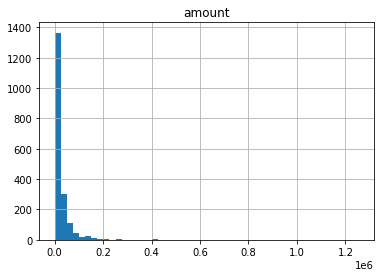

In [3]:
# Amount follows a power rule dist and would likely benefit from a log transform for clustering purposes
df.hist('amount', bins=50)

# Part 1

In [4]:
counter = HashingVectorizer()
    
count_matrix = counter.fit_transform(train.original_description.values)

svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)
transform = svd.fit_transform(count_matrix)

log_transformer = FunctionTransformer(np.log)
amounts = log_transformer.fit_transform(train.amount.values)
amounts = amounts.reshape(amounts.shape[0], -1)
scaler = MaxAbsScaler()

X = np.append(transform, amounts, 1)
X = scaler.fit_transform(X)

clusters = KMeans(n_clusters=20).fit_predict(X)

train['group'] = clusters
train.head(20)

<ipython-input-4-b0538b4e67c3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group'] = clusters


,original_description,amount,group
485,att payment nora indovina,106443,0
1610,withdraw comenity pay oh web pymt,9425,11
966,playstationnetw number,3427,10
1523,bestbuycomnumber,120722,16
32,instacart ca,14165,9
1559,prog county mut ins prem customer name xxxxxnu...,25491,16
1193,comcast,32343,16
915,google google storage,625,3
124,annual membership fee,29845,7
1888,annual membership fee,31102,7


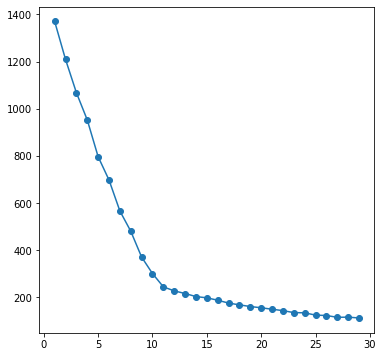

In [11]:
# For fun I made an elbow plot to answer: is there a more ideal number of clusters?
# Though there is no real clear elbow, 10-15 groups may be sufficient to group this data 

sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')

In [6]:
train['group'].value_counts()

16    359
5     112
0     105
9     101
8      90
13     89
7      89
3      86
10     79
11     75
19     68
1      67
17     63
18     63
12     62
4      61
15     50
2      49
14     23
6      20
Name: group, dtype: int64

In [7]:
for i in range(20):
    print(train[train['group'] == i].head(5))

            original_description  amount  group
485    att payment nora indovina  106443      0
49          at t bill payment tx   80667      0
1524                 att payment   60055      0
495             att bill payment   15708      0
289   payment to godaddy com llc    3138      0
           original_description  amount  group
1731     instacart subscription    3138      1
1037     instacart subscription    3138      1
1041  instacart httpsinstacarca   37969      1
1861     instacart subscription    3138      1
591              instacart aldi   26320      1
                                   original_description  amount  group
78               paypal inst xfer hulu web id paypalsi     3767      2
365              subscription acorns hash web id number     314      2
1247  subscription des acorns id number indn email c...     314      2
486   geico des geico pymt id number indn customer n...   23568      2
1380  subscription des acorns id hash indn customer ...     314      2
    

In [8]:
val_counts = counter.transform(holdout.original_description.values)
val_transform = svd.transform(val_counts)
val_amounts = log_transformer.transform(holdout.amount.values)
val_amounts = val_amounts.reshape(val_amounts.shape[0], -1)
X_val = np.append(val_transform, val_amounts, 1)
scaler.transform(X_val)

X_train, X_test, y_train, y_test = train_test_split(X, train.group.values)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f"acc = {metrics.accuracy_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))

acc = 0.9836448598130841
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.91      0.95        22
           2       0.88      1.00      0.93         7
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00        21
           8       1.00      0.85      0.92        20
           9       0.95      1.00      0.98        20
          10       0.88      1.00      0.94        15
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        12
          13       0.95      0.95      0.95        21
          14       1.00      1.00      1.00         6
          15       0.93      1.00      0.97        14
          16       0.99      0.99      0.99        96
  

In [9]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestClassifier()

cv_clf = RandomizedSearchCV(rf, param_distributions=random_grid, n_iter=100, cv=3, 
                            verbose=2, n_jobs=-1)

cv_clf.fit(X_train, y_train)

y_pred = cv_clf.predict(X_test)
print(f"acc = {metrics.accuracy_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
acc = 0.9813084112149533
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      0.91      0.95        22
           2       0.88      1.00      0.93         7
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        29
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00        21
           8       1.00      0.85      0.92        20
           9       0.95      1.00      0.98        20
          10       0.88      1.00      0.94        15
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        12
          13       0.95      0.95      0.95        21
          14       1.00      1.00      1.00         6
          15       0.93      1.00      0.97    

In [10]:
val_predictions = cv_clf.predict(X_val)
holdout['class'] = val_predictions
holdout.head(50)

<ipython-input-10-f84e8b67c871>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout['class'] = val_predictions


,original_description,amount,class
1223,best buy el centro ca sale,11439,16
111,pos purchase progressive insurance oh number,21551,8
554,burger king west babylon ny,8181,16
526,payment to groupon inc,7650,17
1480,direct withdrawal acorns invest transfer,3669,16
1137,kindle svcs ne h ss,3380,16
70,comenity pay il des web pymt id pnumber indn c...,23562,11
251,prog direct ins des ins prem id xxxxxnumber cu...,57922,16
1315,gelsons via instacart,31372,16
1030,visa checking dnh godaddy com az date number c...,24545,8
